# Breast Cancer Classification

Breast cancer is cancer that develops from breast tissue. Signs of breast cancer may include a lump in the breast, a change in breast shape, dimpling of the skin, fluid coming from the nipple, a newly inverted nipple, or a red or scaly patch of skin. In those with distant spread of the disease, there may be bone pain, swollen lymph nodes, shortness of breath, or yellow skin.

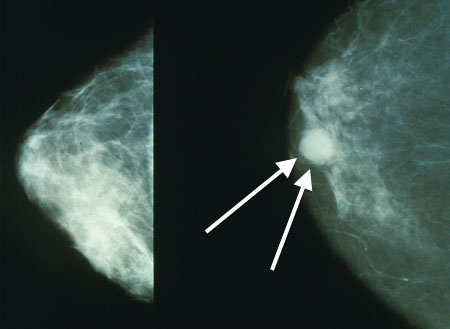

1. [Libraries and Utilities](#2)   
2. [Load and Check Data](#3)   
    - [Malignant to 1 and Bening to 0](#4)
3. [Exploratory Data Analysis](#5)
    - [Correlation Map](#6)
4. [Outlier Detection](#7)
5. [Drop Outliers](#8)
6. [Train Test Split](#9)
7. [Standardization](#10)
8. [Basic KNN Method](#11)
    - [Finding Best KNN Parameters](#12)
9. [Principal Component Analysis](#13)
10. [Neighborhood Component Analysis (NCA)](#14)
    - [Finding Wrong Decision](#15)

<a id = "2"></a>
# Libraries and Utilities

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis, LocalOutlierFactor
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

<a id = "3"></a>
# Load and Check Data

In [ ]:
data = pd.read_csv('/kaggle/input/breast-cancer-wisconsin-data/data.csv')
data.drop(["Unnamed: 32","id"], axis = 1, inplace =True)
data = data.rename(columns = {"diagnosis":"target"})
data.head()

In [ ]:
sns.countplot(data["target"])
print(data.target.value_counts())

<a id = "4"></a>
## Malignant to 1 and Bening to 0

In [ ]:
data["target"] = [1 if i.strip() == "M" else 0 for i in data.target]
print("Data Shape:", data.shape)

<a id = "5"></a>
# Exploratory Data Analysis

<a id = "6"></a>
## Correlation Map

In [ ]:
corr_matrix = data.corr()
f,ax=plt.subplots(figsize = (15,15))
sns.heatmap(corr_matrix,annot= True,fmt = ".1f",ax=ax,cmap='coolwarm',vmin=-1,vmax=1)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Map', size = 14)
plt.show()

In [ ]:
threshold = 0.75
filtre = np.abs(corr_matrix["target"]) > threshold
corr_features = corr_matrix.columns[filtre].tolist()
f,ax=plt.subplots(figsize = (8,8))
sns.heatmap(data[corr_features].corr(),annot= True,fmt = ".2f",ax=ax,cmap='coolwarm',vmin=-1,vmax=1)
plt.xticks(rotation=60)
plt.yticks(rotation=0)
plt.title("Correlation Between Features w Correlation Threshold 0.75", size = 14)
plt.show()

In [ ]:
data_melted = pd.melt(data, id_vars = "target",
                     var_name = "features",
                     value_name = "value")
plt.figure(figsize = (12,6))
sns.boxplot(x = "features", y ="value", hue = "target", data = data_melted)
plt.xticks(rotation = 90);

In [ ]:
sns.pairplot(data[corr_features], diag_kind = "kde", markers = "+", hue = "target")
plt.show()

<a id = "7"></a>
# Outlier Detection

In [ ]:
y = data.target
x = data.drop(["target"], axis = 1)
columns = x.columns.tolist()
columns

In [ ]:
clf = LocalOutlierFactor()
y_pred = clf.fit_predict(x)
X_score = clf.negative_outlier_factor_
outlier_score = pd.DataFrame()
outlier_score["score"] = X_score
outlier_score.head()

In [ ]:
radius = (X_score.max() - X_score) / (X_score.max() - X_score.min())
outlier_score["radius"] = radius
threshold = -2.5
filter_ = outlier_score["score"] < threshold
outlier_index = outlier_score[filter_].index.tolist()
plt.figure(figsize = (12,8))
plt.scatter(x.iloc[outlier_index,0],x.iloc[outlier_index,1], color = "blue", s = 50, label = "Outliers" )
plt.scatter(x.iloc[:,0],x.iloc[:,1], color = "k", s = 3, label = "Data Points" )
plt.scatter(x.iloc[:,0],x.iloc[:,1], s = 1000*radius, edgecolor = "r", facecolors = "none", label ="Outlier Scores")
plt.legend()
plt.show()

<a id = "8"></a>
# Drop Outliers

In [ ]:
x = x.drop(outlier_index)
y = y.drop(outlier_index).values
x.head()

<a id = "9"></a>
# Train Test Split

In [ ]:
test_size = 0.3
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size = test_size, random_state = 42)

<a id = "10"></a>
# Standardization

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
x_train_df = pd.DataFrame(X_train, columns = columns)
x_train_df.head()

In [ ]:
x_train_df.describe()

In [ ]:
x_train_df["target"] = Y_train
data_melted = pd.melt(x_train_df, id_vars = "target",
                     var_name = "features",
                     value_name = "value")

plt.figure(figsize = (14,8))
sns.boxplot(x = "features", y ="value", hue = "target", data = data_melted)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
sns.pairplot(x_train_df[corr_features], diag_kind = "kde", hue = "target")
plt.show()

<a id = "11"></a>
# Basic KNN Method

In [ ]:
knn = KNeighborsClassifier(n_neighbors= 2)
knn.fit(X_train,Y_train)
y_pred =  knn.predict(X_test)
cm = confusion_matrix(Y_test, y_pred)
acc = accuracy_score(Y_test, y_pred)
score = knn.score(X_test, Y_test)
print("Score:", score)
print("CM:", cm)
print("Basic KNN Accuracy:", acc)

<a id = "12"></a>
## Finding Best KNN Parameters

In [ ]:
def KNN_Best_Params(x_train, x_test, y_train,y_test):
    
    k_range = list(range(1,31))
    weight_options = ["uniform","distance"]
    print()
    param_grid = dict(n_neighbors = k_range, weights = weight_options)
    
    knn = KNeighborsClassifier()
    grid = GridSearchCV(knn, param_grid, cv = 10, scoring = "accuracy")
    grid.fit(x_train, y_train)
    
    print("Best Training Score: {} with parameters: {}".format(grid.best_score_, grid.best_params_))
    print()
    
    knn = KNeighborsClassifier(**grid.best_params_)
    knn.fit(x_train,y_train)
    
    y_pred_test = knn.predict(x_test)
    y_pred_train = knn.predict(x_train)
    
    cm_test = confusion_matrix(y_test, y_pred_test)
    cm_train = confusion_matrix(y_train, y_pred_train)
    
    acc_test = accuracy_score(y_test, y_pred_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    
    print("Test Score: {}, Train Score: {}".format(acc_test,acc_train))
    
    print()
    
    print("CM Test:" ,cm_test)
    print("CM Train:", cm_train)
    
    return grid

In [ ]:
grid = KNN_Best_Params(X_train, X_test, Y_train, Y_test)

<a id = "13"></a>
# Principal Component Analysis

In [ ]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

pca = PCA(n_components = 2)
pca.fit(x_scaled)
X_reduced_pca = pca.transform(x_scaled)
pca_data = pd.DataFrame(X_reduced_pca, columns = ["p1","p2"])
pca_data["target"] = y

plt.figure(figsize = (14,8))
sns.scatterplot(x = "p1", y = "p2", hue = "target", data = pca_data)
plt.title("PCA: p1 vs p2")
plt.show()

In [ ]:
X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(X_reduced_pca, y,test_size = test_size, random_state = 42)
grid_pca = KNN_Best_Params(X_train_pca, X_test_pca, Y_train_pca, Y_test_pca)

In [ ]:
cmap_light = ListedColormap(['orange', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', "darkblue"])

h = 0.05
X = X_reduced_pca
x_min, x_max = X[:,0].min() -1, X[:,0].max() + 1
y_min, y_max = X[:,1].min() -1, X[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min,y_max,h))

Z = grid_pca.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure(figsize = (14,8))
plt.pcolormesh(xx,yy,Z, cmap = cmap_light)

plt.scatter(X[:,0], X[:,1], c = y, cmap = cmap_bold,
           edgecolor = 'k', s = 20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("%i-Class Classification (k = %i, weights = '%s')"
         % (len(np.unique(y)), grid_pca.best_estimator_.n_neighbors, grid_pca.best_estimator_.weights))
plt.show()

<a id = "14"></a>
# Neighborhood Component Analysis (NCA)

In [ ]:
nca = NeighborhoodComponentsAnalysis(n_components = 2, random_state = 42)
nca.fit(x_scaled, y)
X_reduced_nca = nca.transform(x_scaled)
nca_data = pd.DataFrame(X_reduced_nca, columns = ["p1","p2"])
nca_data["target"] = y
plt.figure(figsize = (14,8))
sns.scatterplot(x = "p1", y= "p2", hue = "target", data = nca_data )
plt.title("NCA: p1 vs p2")
plt.show()

In [ ]:
X_train_nca, X_test_nca, Y_train_nca, Y_test_nca = train_test_split(X_reduced_nca, y,test_size = test_size, random_state = 42)
grid_nca = KNN_Best_Params(X_train_nca, X_test_nca, Y_train_nca, Y_test_nca)

In [ ]:
cmap_light = ListedColormap(['orange', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', "darkblue"])
h = 0.35
X = X_reduced_nca
x_min, x_max = X[:,0].min() -1, X[:,0].max() + 1
y_min, y_max = X[:,1].min() -1, X[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min,y_max,h))

Z = grid_nca.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure(figsize = (14,8))
plt.pcolormesh(xx,yy,Z, cmap = cmap_light)

plt.scatter(X[:,0], X[:,1], c = y, cmap = cmap_bold,
           edgecolor = 'k', s = 20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("%i-Class Classification (k = %i, weights = '%s')"
         % (len(np.unique(y)), grid_nca.best_estimator_.n_neighbors, grid_nca.best_estimator_.weights));

<a id = "15"></a>
## Finding Wrong Decision

In [ ]:
knn = KNeighborsClassifier(**grid_nca.best_params_)
knn.fit(X_train_nca,Y_train_nca)
y_pred_nca = knn.predict(X_test_nca)
acc_test_nca = accuracy_score(y_pred_nca, Y_test_nca)
print("KNN Accuracy: %{}".format(round(knn.score(X_test_nca, Y_test_nca)*100,2)))

In [ ]:
test_data = pd.DataFrame()
test_data["X_test_nca_p1"] = X_test_nca[:,0]
test_data["X_test_nca_p2"] = X_test_nca[:,1]
test_data["y_pred_nca"] = y_pred_nca
test_data["Y_test_nca"] = Y_test_nca

plt.figure(figsize = (14,8))
sns.scatterplot("X_test_nca_p1", y= "X_test_nca_p2", hue ="Y_test_nca", data = test_data)
diff = np.where(y_pred_nca!= Y_test_nca)[0]
plt.scatter(test_data.iloc[diff,0], test_data.iloc[diff,1],label = "Wrong Classified", alpha = 0.2,color = "red", s = 1000)
plt.show()